In [4]:
from __future__ import division
import numpy as np
import numpy.ma as nma
from pio import imgio
import apply_mask
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
rc('text', usetex=True)
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from lmfit import Model
from pydmd import DMD
from pydmd import FbDMD
from copy import deepcopy

%matplotlib inline

In [144]:
# Image, Velocity & Mask File Definitions
img_file = '../Analysis/test/cam2_still_50a.bsub.img'
W_file = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.npy'
msk_file = '../Analysis/test/cam2_still_50a.bsub.0032.def.mask.npy'
# other files
# time-averaged mask
tave_mask = '../Analysis/test/cam2_still_50a.bsub.0032.def.mask.tave_mask.npy'
# average vertical velocity
avg_W = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.ave.npy'
#fluctuating vertical velocity
flct_W = '../Analysis/test/cam2_still_50a.bsub.0032.def.W.flct.npy'
deltat = 1/300 #s
cal = 1.8e3 #pix/m
D_0 = 0.0508 #m

In [145]:
# load in files
img = imgio.imgio(img_file)
piv = apply_mask.apply_mask(W_file,msk_file)

W_bar = apply_mask.apply_mask(avg_W,tave_mask)
W_prime = apply_mask.apply_mask(flct_W,msk_file)

### Particle Flux

In [7]:
# Average concentration map (aka average of raw images)
light_map = np.loadtxt('../Analysis/test/cam2_ave_lightmap.txt.gz')
I_correction = ndimage.filters.gaussian_filter((np.max(light_map)/light_map),50)
mean_c = img.read_frame2d(0).astype(int)
for f in range(1,img.it):
    t = img.read_frame2d(f)
    t[t<150]=0
    mean_c += t
mean_c = (mean_c / img.it)*I_correction

In [8]:
max_phi = 1e-3
mean_c_phi = mean_c/np.max(mean_c)*max_phi

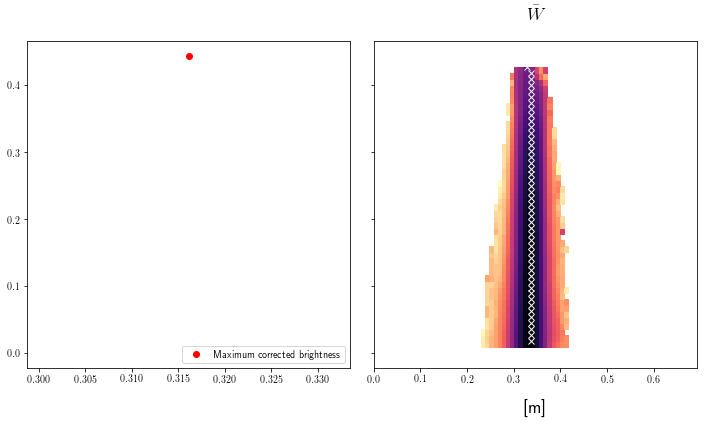

In [6]:
f,ax = plt.subplots(1,2,figsize=(10,6),sharey=True)
#X,Z = np.meshgrid(np.linspace(0,img.ix-1,img.ix)/cal, np.linspace(0,img.iy-1,img.iy)/cal)
#ax[0].pcolormesh(X,Z,mean_c,cmap=cm.gray,vmin=1000,vmax=10000);
#ax[0].set_title(r'$\bar{c}$',y=1.05,fontsize=18);
Xv,Zv = np.meshgrid(np.linspace(0,W_bar.shape[1]-1,W_bar.shape[1])*16/cal, np.linspace(0,W_bar.shape[0]-1,W_bar.shape[0])*16/cal)
ax[1].pcolormesh(Xv,Zv,W_bar,cmap=cm.magma);
ax[1].plot()
ax[1].set_title(r'$\bar{W}$',y=1.05,fontsize=18);
ax[1].set_xlabel('[m]',labelpad=15,fontsize=18)
#ax[0].set_xlabel('[m]',labelpad=15,fontsize=18)
#ax[0].set_ylabel('[m]',labelpad=15,fontsize=18)
#ax[0].set_ylim(0,np.max(Z))
plt.tight_layout()
centerline = np.zeros((2,W_bar.shape[0]))
for r in range(0,W_bar.shape[0]):
    centerline[0,r] = r
    try:
        centerline[1,r] = (np.where(W_bar[r,:] == nma.min(W_bar[:,:],axis=1)[r])[0])
    except:
        centerline[1,r] = np.nan
centerline_pix = (centerline*16+16.5)
Z = (800-centerline_pix[0])/cal/D_0
#R = 
ax[1].plot(centerline_pix[1]/cal,centerline_pix[0]/cal,'wx');
ax[0].plot(np.where(mean_c==np.max(mean_c))[1]/cal,np.where(mean_c==np.max(mean_c))[0]/cal,'ro')
ax[0].legend(['Maximum corrected brightness'],loc=4);

In [9]:
# calculate mean concentration on PIV grid
c_map = np.zeros(W_bar.shape)
c_map2 = np.zeros(W_bar.shape)
mean_c2 = mean_c/I_correction
for r in range(8,img.iy-8,16):
    for c in range(8,img.ix-8,16):
        #print int(r/16),int(c/16) 
        c_map[int(r/16),int(c/16)] = np.mean(mean_c_phi[slice(r,r+16,1),slice(c,c+16,1)])
        c_map2[int(r/16),int(c/16)] = np.mean(mean_c2[slice(r,r+16,1),slice(c,c+16,1)])

In [10]:

W_plume=W_bar#nma.masked_greater(W_bar,-5)
#(c_map[:,0:38]).max()


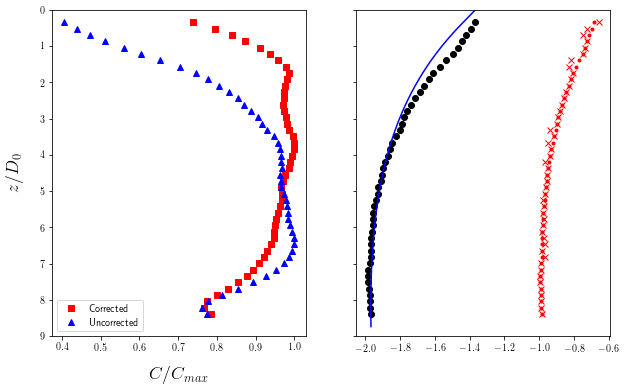

In [18]:
centerline = np.zeros((2,W_bar.shape[0]))
for r in range(0,W_bar.shape[0]):
    centerline[0,r] = r
    try:
        centerline[1,r] = (np.where(W_bar[r,:] == nma.min(W_bar[:,:],axis=1)[r])[0])
    except:
        centerline[1,r] = np.nan
centerline_pix = (centerline*16+16.5)
Z = (800-centerline_pix[0])/cal/D_0
#centerline concentration and velocity
f,ax = plt.subplots(1,2,figsize=(10,6),sharey=True)
#ax[0].plot(c_map[centerline[0][1:-1].astype('int'),
#                 centerline[1][1:-1].astype('int')]/np.max(c_map),Z[1:-1],'rs',
#          c_map2[centerline[0][1:-1].astype('int'),
#                 centerline[1][1:-1].astype('int')]/np.max(c_map2),Z[1:-1],'b^')
ax[0].plot(np.sum(c_map,axis=1)[1:-1]/np.max(np.sum(c_map,axis=1)[1:-1]),Z[1:-1],'rs',
          np.sum(c_map2,axis=1)[1:-1]/np.max(np.sum(c_map2,axis=1)[1:-1]),Z[1:-1],'b^')
ax[0].legend(['Corrected','Uncorrected'])
ax[0].set_xlabel('$C/C_{max}$',labelpad=15,fontsize=18)
ax[0].set_ylabel('$z/D_0$',labelpad=15,fontsize=18)
ax[0].set_ylim(9,0);

ax[1].plot(nma.min(W_plume[:,:],axis=1)/cal/deltat,Z,'ko')
#ax[1].plot(np.polyval(np.polyfit(Z[35:-1],nma.min(W_bar[:,:],axis=1)[35:-1].data,1)/cal/deltat,Z[35:-1]),Z[35:-1],'g-',linewidth=4)
#ax[1].text(-1.9,1.5,r'$\frac{dw_z}{dz}=-7.8$ [1/s]',fontsize=15,color='darkgreen')
#ax[1].set_xlabel('$W_c$ [m/s]',labelpad=15,fontsize=18);
ax[1].plot(tophat,Z[1:-1],'rx')
ax[1].plot(nma.min(W_plume[:,:],axis=1)/cal/deltat/2,Z,'r.')

ax[1].plot(-wp[0:-1],s/cal/D_0,'b-');


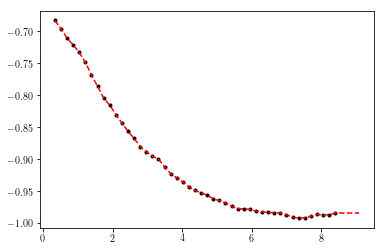

In [348]:
plt.plot(Z,nma.min(W_plume[:,:],axis=1)/cal/deltat/2,'k.')
p=np.interp(s/cal/D_0,np.flip(Z[1:-1]),np.flip(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2))
plt.plot(s/cal/D_0,p , 'r--')

In [301]:
p

array([-0.75607336, -0.27539706])

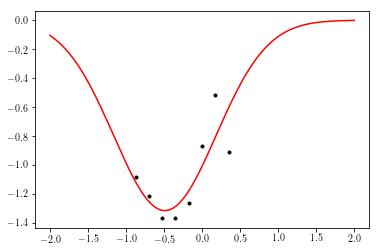

In [14]:
#plt.plot(Z,nma.min(W_plume[:,:],axis=1)/cal/deltat/2)
plt.plot(X,W_bar[i,:]/cal/deltat,'k.')
#plt.plot(X,gaussian(X,popt[0],popt[1],popt[2])/cal/deltat)
#plt.plot(x, result.init_fit, 'k--')
plt.plot(np.linspace(-2,2,300), gaussian(np.linspace(-2,2,300),result.best_values['a'],result.best_values['x0'],result.best_values['sigma']), 'r-')

In [8]:
X = np.arange(0,79)*16/cal/D_0-np.mean(np.arange(0,79)*16/cal/D_0)
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
tophat=[]
for i in range(1,W_bar.shape[0]-1):
    n = np.sum(~W_bar[i,:].mask)
    y = W_bar[i,:][~W_bar[i,:].mask].data
    x = X[~W_bar[i,:].mask]
    mean = nma.sum(x*y)/n                  
    sigma = nma.sum(y*(x-mean)**2)/n
    #popt,pcov = curve_fit(gaussian,x,y,p0=[nma.min(W_bar[i,:]),mean,sigma])
    gmodel = Model(gaussian)
    params = gmodel.make_params(a=nma.min(W_bar[i,:])/cal/deltat,x0=nma.sum(x*y)/n,sigma=nma.sum(y*(x-mean)**2)/n)
    if i==47:
        params['sigma'].min=-1
        params['sigma'].max=0
        params['x0'].min=-1
        params['x0'].max=-.25
        params['a'].min=nma.min(y/cal/deltat)*1.25
        params['a'].max=nma.min(y/cal/deltat)*.6
    else:
        params['sigma'].min=-1
        params['sigma'].max=1
        params['x0'].min=-1
        params['x0'].max=-.25
        params['a'].min=nma.min(y/cal/deltat)*1.25
        params['a'].max=nma.min(y/cal/deltat)*.75
    result = gmodel.fit(W_bar[i,:][~W_bar[i,:].mask].data/cal/deltat, params, x=X[~W_bar[i,:].mask])
    tophat.append(result.best_values['a']/2)
tophat = np.asarray(tophat)

In [237]:
from lmfit.models import ExponentialGaussianModel as EGM
i=47
gmodel = Model(gaussian)
n = np.sum(~W_bar[i,:].mask)
y = W_bar[i,:][~W_bar[i,:].mask].data
x = X[~W_bar[i,:].mask]
mean = nma.sum(x*y)/n                  
sigma = nma.sum(y*(x-mean)**2)/n
params = gmodel.make_params(a=nma.min(y)/cal/deltat,x0=nma.sum(x*y)/n,sigma=nma.sum(y*(x-mean)**2)/n)
params['sigma'].min=-1
params['sigma'].max=0
params['x0'].min=-1
params['x0'].max=-.25
params['a'].min=nma.min(y/cal/deltat)*1.25
params['a'].max=nma.min(y/cal/deltat)*.6
result = gmodel.fit(y/cal/deltat, params, x=x)
#popt,pcov = curve_fit(gaussian,x,y,p0=[nma.min(W_bar[i,:]),mean,sigma])

# Calculation of:
# $\overline{wc} = \bar{w}\bar{c} + \overline{w^{\prime}c^{\prime}}$

In [ ]:
WC = np.zeros(piv.shape)
WpCp = np.zeros(piv.shape)
I_max = 0
for f in range(1,piv.shape[0]):
    C = img.read_frame2d(f)*I_correction
    cf = C - mean_c
    temp=np.zeros(W_bar.shape)
    temp2=np.zeros(W_bar.shape)
    temp3=np.zeros(W_bar.shape)
    for r in range(8,img.iy-8,16):
        for c in range(8,img.ix-8,16):
            #print int(r/16),int(c/16)
            temp[int(r/16),int(c/16)] = np.mean(C[slice(r,r+16,1),slice(c,c+16,1)])
            temp2[int(r/16),int(c/16)] = np.mean(cf[slice(r,r+16,1),slice(c,c+16,1)])
            temp3[int(r/16),int(r/16)] = np.mean(C[slice(r,r+16,1),slice(c,c+16,1)])
    if np.max(temp)> I_max:
        I_max = np.max(temp)
    temp = temp/I_max
    temp2 = temp2/I_max
    WpCp[f,:,:] = temp2*-W_prime[f]/cal/deltat
    WC[f,:,:] = temp*(-piv[f]/cal/deltat)
#del temp, C    

In [ ]:
temp2.min()

In [ ]:
WC_bar = np.mean(WC,axis=0)
f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz(WC_bar,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\overline{wc}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

In [ ]:

f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz((c_map/I_max)*-W_bar/cal/deltat,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\bar{w} \bar{c}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

In [ ]:
WpCp_bar = np.mean(WpCp,axis=0)
f,ax = plt.subplots(figsize=(6,6))
ax.plot(np.trapz(WpCp_bar,dx=1/cal,axis=1),Z,'ko')
ax.set_ylim(9,0);
ax.set_xlabel(r'$\int{\overline{w^{\prime}c^{\prime}}}dx$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

In [ ]:
C = img.read_frame2d(0)*I_correction
cf = C - mean_c

In [17]:
W_plume=nma.masked_greater(W_bar,-4.5)

In [27]:
r[0]

array([  8,  24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200,
       216, 232, 248, 264, 280, 296, 312, 328, 344, 360, 376, 392, 408,
       424, 440, 456, 472, 488, 504, 520, 536, 552, 568, 584, 600])

# Plume classification through the Gamma function

In [58]:
r = np.arange(8,38*16,16).reshape(1,38)
r = r.repeat(W_plume.shape[0],axis=0)
JQ = abs(2*np.pi*np.sum(W_plume[:,0:38]*r,axis=1))
JM = abs(2*np.pi*np.sum(W_plume[:,0:38]**2*r,axis=1))
JB = abs(2*np.pi*np.sum(W_plume[:,0:38]*(((1-c_map[:,0:38])*1.225 + c_map[:,0:38]*2500)-1)*r,axis=1))
Q = JQ/np.pi
M = 2*JM/np.pi
F = 2*JB/np.pi
alpha = 0.03
Gamma = (5*Q**2*F)/(4*alpha*M**(5/2))
#Gamma[14:30]=Gamma[14:30]-(Gamma[14]-Gamma[13])+np.mean(np.gradient(Gamma[0:13]))
#Gamma[30]=Gamma[30]-(Gamma[30]-Gamma[29])+np.mean(np.gradient(Gamma[14:29]))
#Gamma[31:]=Gamma[31:]-(Gamma[31]-Gamma[30])+np.mean(np.gradient(Gamma[14:30]))

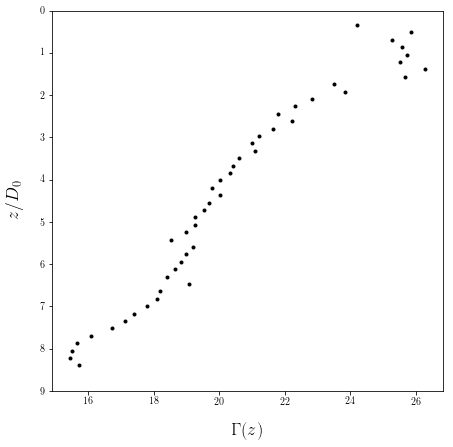

In [59]:
f,ax = plt.subplots(figsize=(7,7))
ax.plot(Gamma,Z,'k.')
ax.set_ylim(9,0);
ax.set_xlabel('$\Gamma (z)$',labelpad=15,fontsize=18)
ax.set_ylabel('$z/D_0$',labelpad=15,fontsize=18);

# Liu's Numerical Model for Particle Plumes

In [11]:
beta_0 = 1e-3 # volume fraction
rho_p = 2500 # kg/m^3
rho_a = 1.225 # kg/m^3
g = 9.81 # m/s^2
w_0 = -nma.min(W_plume[1:-1,:],axis=1)[-1]/cal/deltat # m/s
r_0 = .0508/2 # m
dp = 52e-6 #m
tau_p = 17e-3 # s
mu_a = 1.825e-5 # kg m^-1 s^-1


steps = 10000
length = 8000
s = np.arange(0,length,length/steps)
s_size = np.diff(np.arange(1,length,length/steps))[0]
w_a0 = w_0-(tau_p*g)
r_a0 = r_0
alpha = 0.03
Q_a0 = np.pi*r_a0**2*w_a0
M_a0 = w_a0*Q_a0*rho_a
m_dot = 5.8e-3 # kg/s


B = (rho_p - rho_a)*np.pi*g*beta_0*w_0*r_0**2
K1 = 15/2*np.pi*beta_0*w_0*r_0**2*rho_a**(-1/3)*mu_a**(2/3)*dp**(-5/3)


In [12]:
wp = np.zeros((steps+1,))
wa = np.zeros((steps+1,))
Qa = np.zeros((steps+1,))
Ma = np.zeros((steps+1,))
ra = np.zeros((steps+1,))
wp[0] = w_0
wa[0] = w_a0
Qa[0] = Q_a0
ra[0] = r_0
Ma[0] = M_a0
C = np.zeros((steps+1))
#cs=np.linspace(.1,100,100000)
#Rep = (rho_a*(w_0-w_a0)*dp)/mu_a
#Cd = 24*(1+0.15*Rep**.687)/Rep
#Fd = rho_a*(w_0-w_a0)**2/2*Cd/4*np.pi*dp**2*cs*6*beta_0*w_0*r_0**2/dp**3
#w = wp[0] + s_size/cal * (B-Fd)/(m_dot*wp[0])
#interp_diff = abs(w+np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
#C[0] = cs[np.where(interp_diff==np.min(interp_diff))[0]]
C=1
for i,ii in enumerate(s):
    i=i+1
    ii=ii+s_size
    Rep = (rho_a*(wp[i-1]-wa[i-1])*dp)/mu_a
    Cd = 24*(1+0.15*Rep**.687)/Rep
    Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C*6*beta_0*w_0*r_0**2/dp**3
    wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(m_dot*wp[i-1])
    Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*wa[i-1]*alpha)
    Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
    wa[i] = Ma[i]/(Qa[i]*rho_a)
    ra[i] = np.sqrt(Ma[i]/(np.pi*wa[i]))
    #interp_diff = abs(wp[i]+np.interp(s[i],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
    #C[i] = cs[np.where(interp_diff==np.min(interp_diff))[0]]
    #print wp[i],Qa[i],Ma[i],wa[i],ra[i],'\n'cs[np.where(interp_diff==np.min(interp_diff))[0]]

In [18]:
i=1
C=10
Rep = (rho_a*(wp[i-1]-wa[i-1])*dp)/mu_a
Cd = 24*(1+0.15*Rep**.687)/Rep*C
Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*6*beta_0*w_0*r_0**2/dp**3
wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(m_dot*wp[i-1])
Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*wa[i-1]*alpha)
Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
wa[i] = Ma[i]/(Qa[i]*rho_a)
ra[i] = np.sqrt(Ma[i]/(np.pi*wa[i]))
print Rep, Cd, Fd,B, wp[i], B-Fd
print Qa[i], Ma[i],wa[i],ra[i]

0.582095835616 454.947368359 0.619197650003 0.0678944752207 1.3356213925 -0.551303174782
0.00243427392756 0.00377531611985 1.26604104624 0.0308090162876


In [623]:
i=2
(rho_a*(wp[i-1]-wa[i-1])*dp)/mu_a

0.557150550670179

In [624]:
cs=np.linspace(.1,100,100000)
Rep = (rho_a*(w_0-w_a0)*dp)/mu_a
Cd = 24*(1+0.15*Rep**.687)/Rep
Fd = rho_a*(w_0-w_a0)**2/2*Cd/4*np.pi*dp**2*cs*6*beta_0*w_0*r_0**2/dp**3
w = wp[0] + s_size/cal * (B-Fd)/(m_dot*wp[0])
interp_diff = abs(w+np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
wp[0]

0.6832678318135531

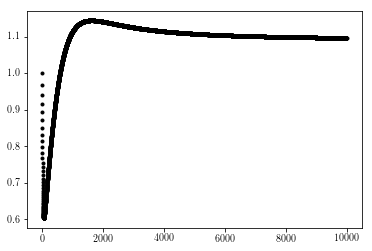

In [27]:
plt.plot((wp-wa)/(tau_p*g),'k.')

In [450]:
C = np.zeros((steps+1))
cs=np.linspace(.1,100,100000)
Rep = (rho_a*(w_0-w_a0)*dp)/mu_a
Cd = 24*(1+0.15*Rep**.687)/Rep
Fd = rho_a*(w_0-w_a0)**2/2*Cd/4*np.pi*dp**2*cs*6*beta_0*w_0*r_0**2/dp**3
w = wp[0] + s_size/cal * (B-Fd)/(m_dot*wp[0])

In [451]:
interp_diff = abs(w+np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
cs[np.where(interp_diff==np.min(interp_diff))[0]]


array([0.1])

In [616]:
s

array([0.00000e+00, 8.00000e-01, 1.60000e+00, ..., 7.99976e+04,
       7.99984e+04, 7.99992e+04])

In [477]:
np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2))

-0.6832678318135531

In [285]:
scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T)

array([ 7.45536096])

# Dynamic Mode Decomposition

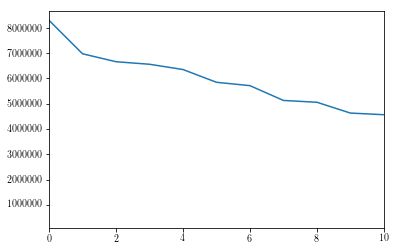

In [336]:
import scipy
frames = 1000
snapshots = np.asarray([img.read_frame2d(i)[:,400:800]*I_correction[:,400:800] for i in range(0,frames)],dtype='float') - np.repeat(mean_c[:,400:800].reshape(1,800,400),frames,axis=0)
#snapshots = piv[0:frames,:,:] - np.repeat(W_bar.reshape(1,49,79),frames,axis=0)
#snapshots = W_prime[0:frames,:,:]
#snapshots.data[snapshots.mask]=0
#snapshots = snapshots.data/cal/deltat
#snapshots_shape = input_shapes[0]
fig = plt.plot(scipy.linalg.svdvals(np.array([snapshot.flatten() for snapshot in snapshots]).T), '-')
plt.xlim(0,10);
#plt.ylim(.1,1e4)

In [ ]:
dmd = DMD(svd_rank = 5 ,exact=True,opt=True)
#from pydmd import MrDMD
#dmd=MrDMD(svd_rank=-1, max_level=7, max_cycles=1)
dmd.fit(snapshots)

In [ ]:
dmd.plot_eigs()
#dmd.plot_snapshots_2D()

In [574]:
pmodes = dmd.partial_modes(level=1)
#fig = plt.plot(x, pmodes.real)
np.sum(pmodes.real)


def make_plot(X, x=None, y=None, figsize=(12, 8), title=''):
    """
    Plot of the data X
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    X = np.real(X)
    CS = plt.pcolor(x, y, X)
    cbar = plt.colorbar(CS)
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.show()



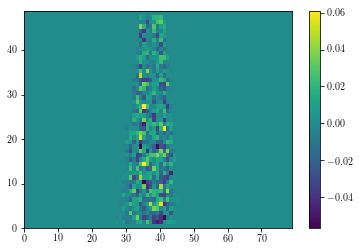

In [270]:
plt.pcolormesh(dmd.modes[:,18].reshape(49,79).real)
plt.colorbar()

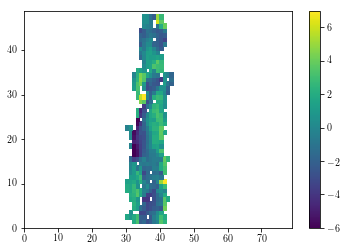

In [184]:
plt.pcolormesh(piv[15,:,:]-W_bar[:,:],vmin=-6,vmax=7)
plt.colorbar()

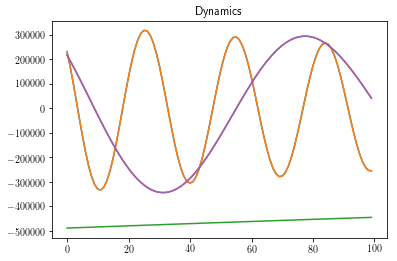

In [333]:
for dynamic in dmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('Dynamics')
plt.show()

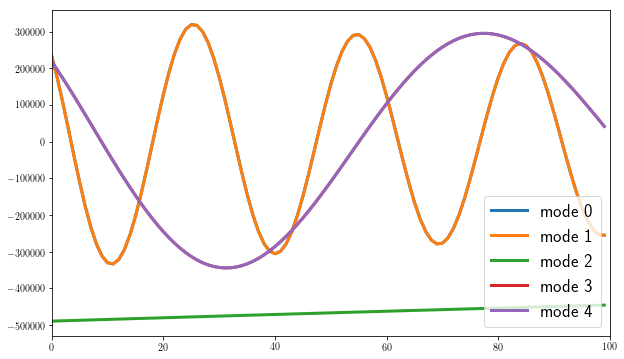

In [335]:
mode=0
f,ax = plt.subplots(figsize=(10,6))
lines = []
labels = []
for m in range(0,5):
    lines+=ax.plot(dmd.dynamics[m,:],'-',linewidth=3)
    labels.append(m)
ax.set_xlim(0,100)
labels
label = ['mode %d' %m for m in labels]
plt.legend(lines, label,loc=4,fontsize=18);

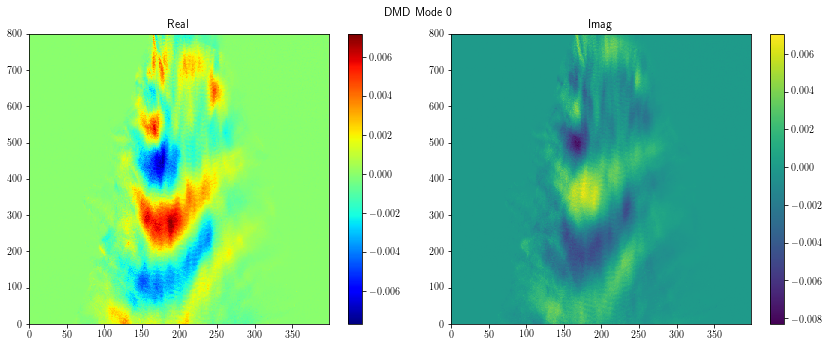

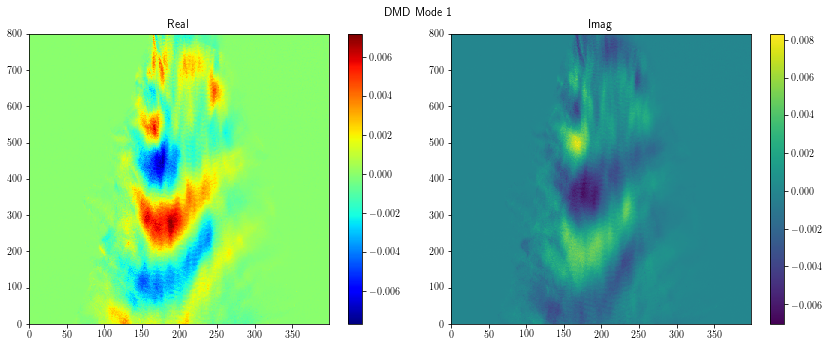

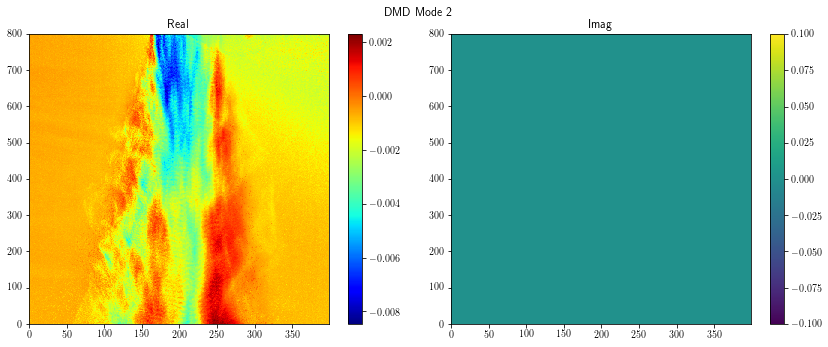

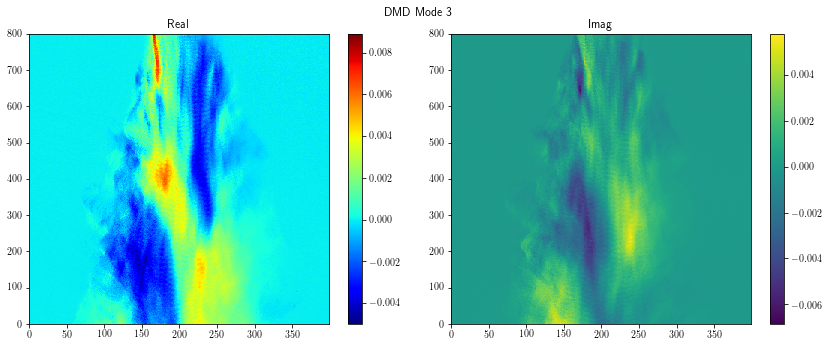

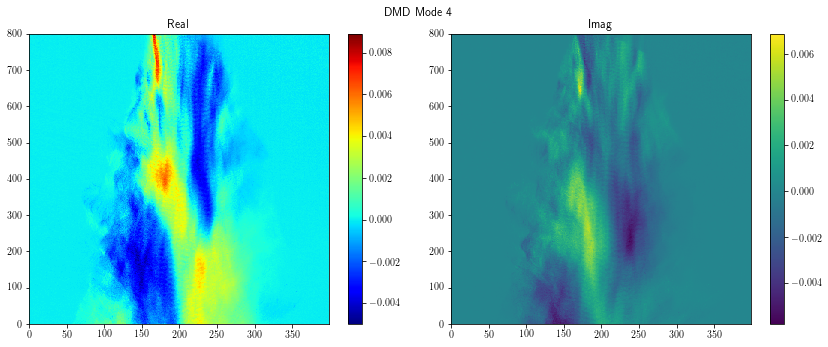

In [331]:
dmd.plot_modes_2D(x=np.arange(0,400),y=np.arange(0,800),figsize=(12,5))
#x = np.arange(0,79)
#t=np.arange(0,49)

#pdata = dmd.partial_reconstructed_data(level=1)
#make_plot(pdata.T, x=x, y=t, title='level 0', figsize=(7.5, 5))

#for i in range(2, 7):
#    pdata += dmd.partial_reconstructed_data(level=i)
#pdata = pdata.reshape(49,79,frames)
#make_plot(pdata.T, x=x, y=t, title='levels 0-' + str(i), figsize=(7.5, 5))

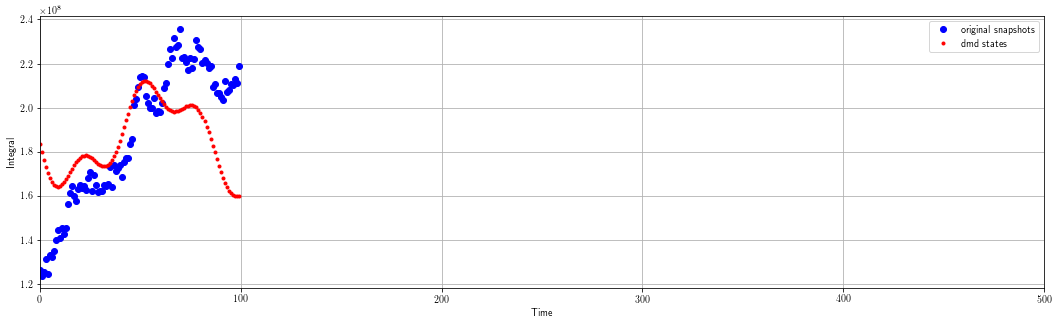

In [332]:
compute_integral = scipy.integrate.trapz
x1 = np.arange(0,800)
x2 = np.arange(0,400)
x1grid, x2grid = np.meshgrid(x1, x2)
dmd_states = [state.reshape(x1grid.shape) for state in dmd.reconstructed_data.T]
original_int = [compute_integral(compute_integral(snapshot)).real for snapshot in snapshots]
dmd_int = [compute_integral(compute_integral(state)).real for state in dmd_states]

figure = plt.figure(figsize=(18, 5))
plt.plot(dmd.original_timesteps, original_int, 'bo', label='original snapshots')
plt.plot(dmd.dmd_timesteps, dmd_int, 'r.', label='dmd states')
plt.ylabel('Integral')
plt.xlabel('Time')
plt.grid()
leg = plt.legend()
plt.xlim(0,500);

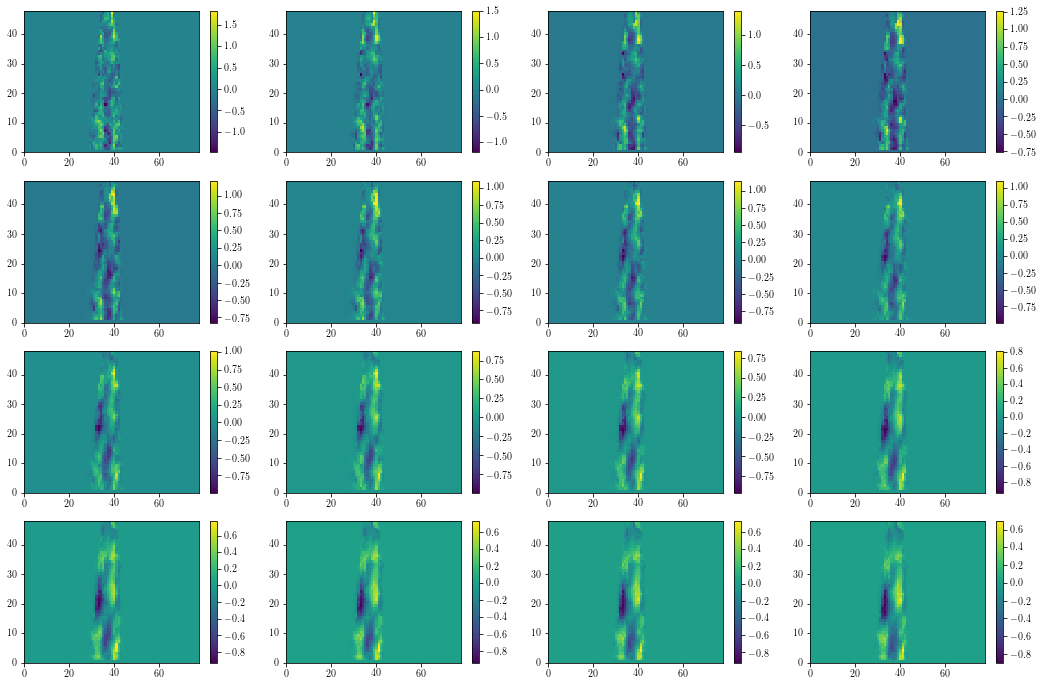

In [272]:
fig = plt.figure(figsize=(18,12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T[0:16], start=1):
    plt.subplot(4, 4, id_subplot)
    plt.pcolor(x1grid, x2grid, snapshot.reshape(x1grid.shape).real)
    plt.colorbar()

(16, 3871)

## Compare DMD to POD

In [273]:
from numpy.linalg import inv, eig, pinv
from scipy.linalg import svd, svdvals
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos, cosh, tanh, real, imag
from numpy.linalg import inv, eig, pinv
from scipy.linalg import svd, svdvals
from scipy.integrate import odeint, ode, complex_ode

In [304]:
frames = 2
snapshots = piv[0:frames,:,:] - np.repeat(W_bar.reshape(1,49,79),frames,axis=0)
snapshots.data[snapshots.mask]=0
snapshots = snapshots.data
data = snapshots.reshape(frames,49*79).T

In [307]:
U,S,V = svd(data,full_matrices=False)

In [308]:
Phi = data*U
#for i in range(0,frames-1):
#    Phi[:,i] = Phi[:,i]/np.linalg.norm(Phi[:,i],2)

In [309]:
lam = np.diag(S)

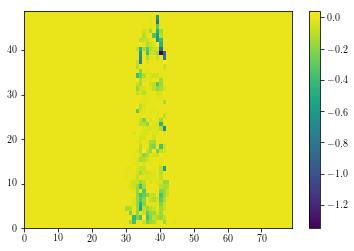

In [310]:
mode = 0
plt.pcolormesh(Phi[:,mode].reshape(49,79))
plt.colorbar()

In [311]:
phis = Phi[:,0].reshape(49,79)
for m in range(1,100):
    phis+=Phi[:,m].reshape(49,79)
phis = phis/(m+1)
plt.pcolormesh(phis)
plt.colorbar()

IndexError: index 2 is out of bounds for axis 1 with size 2

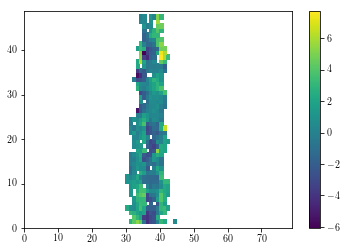

In [312]:
plt.pcolormesh(piv[1,:,:]-W_bar)
plt.colorbar()

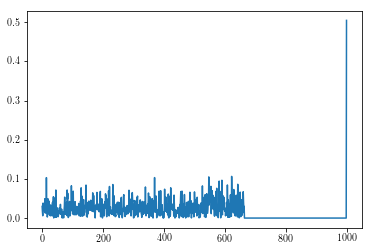

In [97]:
plt.plot(np.abs(V[:,0]));

In [531]:
V[:,1]

array([-0.01077281, -0.00364224,  0.00314406, ...,  0.01616431,
        0.01243863,  0.00720542])

In [537]:
np.sum(lam[0])

86.64479362766663

In [542]:
lam[np.nonzero(lam)].shape

(3000,)

In [164]:
data.shape

(500, 320000)

In [171]:
lam.shape

(500, 500)